# Few-shot Adaptation with Model Agnostic Meta-Learning (MAML)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jaxopt/blob/main/docs/notebooks/deep_learning/maml.ipynb)


This notebook shows how to use Model Agnostic Meta-Learning (MAML) for few-shot adaptation on a simple regression task. This example appears in section 5.1 of [(Finn et al. 2017)](https://arxiv.org/pdf/1703.03400.pdf). The problem is however solved using *implicit* MAML formulation of [(Rajeswaran et al., 2019)](https://arxiv.org/pdf/1909.04630.pdf).


In [1]:
from typing import Any, Callable, Sequence, Optional


import jax
from jax import numpy as jnp
from jax import random

from jaxopt import LBFGS
from jaxopt import GradientDescent
from jaxopt import tree_util

# we use haiku to construct a small multi-layer perceptron
import haiku as hk

from flax import linen as nn

# for plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm


n_tasks = 4

# Problem setup

We consider a multi-task problem, where each task involves regressing from the input to the output of a sine wave. The different tasks have different amplitude and phase of the sinusoid.

In [2]:
def generate_task(key, n_samples_train=10, n_samples_test=10, min_phase=0.5, max_phase=jnp.pi, min_x=-5., max_x=5, min_amplitude=0.1, max_amplitude=0.5):
    """Generate a toy 1-D regression dataset."""
    amplitude = random.uniform(key) * (max_amplitude - min_amplitude) + min_amplitude
    
    key, _ = random.split(key)
    phase = random.uniform(key) * (max_phase - min_phase) + min_phase

    key, _ = random.split(key)
    x_train = random.uniform(key, shape=(n_samples_train,)) * (max_x - min_x) + min_x
    x_train = x_train.reshape((-1, 1))  # Reshape to feed into MLP later
    y_train = jnp.sin(phase * x_train) * amplitude

    key, _ = random.split(key)
    x_test = random.uniform(key, shape=(n_samples_test,)) * (max_x - min_x) + min_x
    x_test = x_test.reshape((-1, 1))  # Reshape to feed into MLP later
    y_test = jnp.sin(phase * x_test) * amplitude

    return (x_train, y_train), (x_test, y_test), phase, amplitude

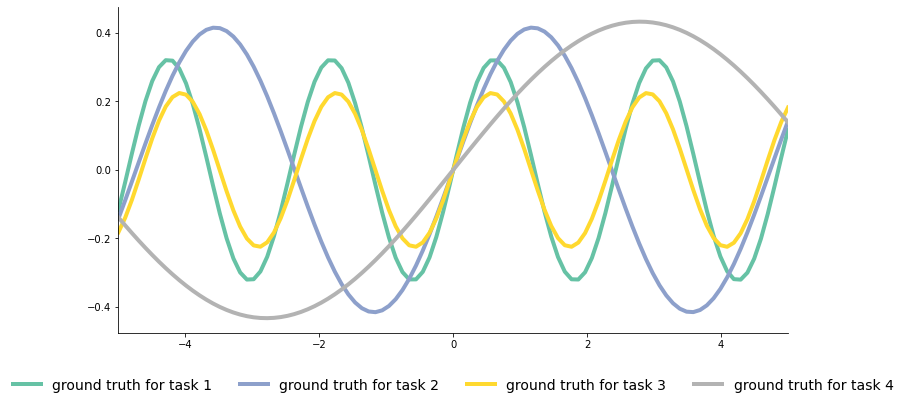

In [3]:
key = random.PRNGKey(0)
fig = plt.figure(figsize=(12, 6))

colors = cm.Set2(jnp.linspace(0, 1, n_tasks))

data_tasks = []
for task in range(n_tasks):

    key, subkey = random.split(key)
    data_train, data_test, phase, amplitude = generate_task(key)
    # save the samples for later
    data_tasks.append((data_train, data_test))

    # generate the ground truth regression curve for plotting
    xs = jnp.linspace(-5, 5, 100)
    ys = jnp.sin(phase * xs) * amplitude
    plt.plot(xs, ys, linewidth=4, label=f'ground truth for task {task+1}', color=colors[task])

plt.xlim((-5, 5))
plt.legend(loc='upper center', fontsize=14, bbox_to_anchor=(0.5, -0.1), frameon=False, ncol=n_tasks)
# Hide the right and top spines
ax = plt.gca()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.show()

The data that we have access to for training the meta-learning model are samples drawn uniformly from the above curves:

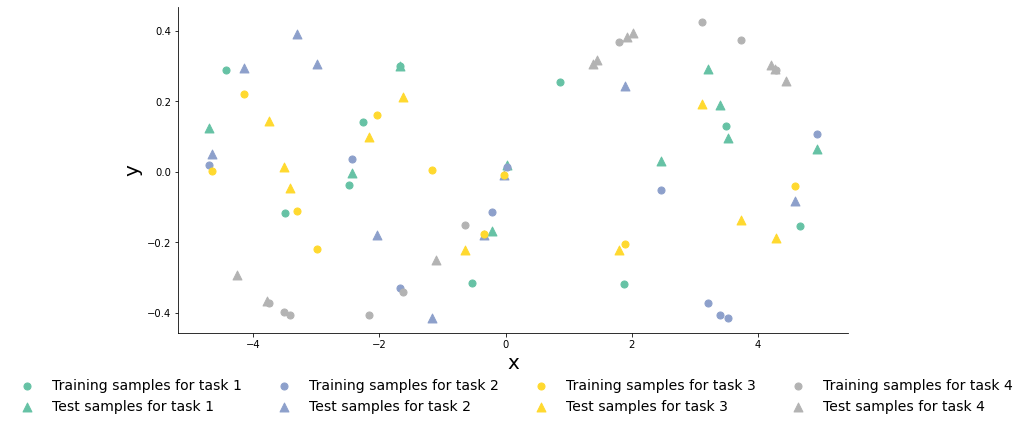

In [4]:


fig = plt.figure(figsize=(12, 6))
for task, ((x_train, y_train), (x_test, y_test)), in enumerate(data_tasks):
    plt.scatter(x_train, y_train, marker='o', s=50, label=f"Training samples for task {task+1}", color=colors[task])
    plt.scatter(x_test, y_test, marker='^', s=80, label=f"Test samples for task {task+1}", color=colors[task])
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
plt.legend(loc='upper center', fontsize=14, bbox_to_anchor=(0.5, -0.1), frameon=False, ncol=n_tasks)
ax = plt.gca()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.show()

XXX we have both a train and a test set. Train and test are of the same size.



 The goal of the meta-learning algorithm is to learn a predictive model with parameters $\theta$ such that a model trained with a loss $f(\cdot) + \frac{}{}\|\cdot - \theta\|^2$ has an error on the test set as small as possible.  XXX doesn't make total sense.

Let $K$ denote the total number of tasks, and $p$ denote the number of parameters in XXX. 
[(Rajeswaran et al., 2019)](https://arxiv.org/pdf/1909.04630.pdf) frame this as the following bi-level problem


$$
\argmin_{\theta} \sum_{i=1}^K \mathcal{L_i}(x_i(\theta)) \text{ subject to } x_i(\theta) = \argmin_{x} \hat{\mathcal{L}}_i(x) + \frac{\lambda}{2}\|x - \theta\|^2\,,
$$

where $\mathcal{L_i}$ is the loss in the train set and $\hat{\mathcal{L_i}}$ is the loss on the test set.



In JAXOpt we can easily write the bi-level optimization problem in a single function


In [5]:
class SimpleMLP(nn.Module):
  features: Sequence[int]

  @nn.compact
  def __call__(self, inputs):
    x = inputs
    for i, feat in enumerate(self.features):
      x = nn.Dense(feat, name=f'layers_{i}')(x)
      if i != len(self.features) - 1:
        x = nn.relu(x)
    return x


The regressor is a neural network model with 2 hidden layers of size 40 with ReLU nonlinearities.

In [6]:

def inner_loss(x, theta, data, regularization=1e-2):
    samples, targets = data
    prediction = model.apply(x, samples)
    mse = jnp.mean((prediction - targets)**2)
    x_m_theta = tree_util.tree_add_scalar_mul(x, -1, theta)
    reg = (regularization / 2) * tree_util.tree_l2_norm(x_m_theta, squared=True)
    return mse + reg

#@jax.jit
def outer_loss(outer_parameters, inner_parameters):
    # inner parameters is passed 
    loss = 0.
    # iterate on the first K-1 tasks
    for i, (train, test) in enumerate(data_tasks[:-1]):
        inner_parameters[i], _ = GradientDescent(inner_loss, maxiter=5000).run(inner_parameters[i], outer_parameters, train)
        samples, targets = test
        prediction = model.apply(inner_parameters[i], samples)
        loss += jnp.mean((prediction - targets)**2)
        #print(loss)
    return loss, inner_parameters

In [7]:
key, subkey = random.split(random.PRNGKey(0), 2)
dummy_input = random.uniform(key, (1,))

model = SimpleMLP(features=[40, 40, 1])
inner_parameters = []
for _ in data_tasks:
  key, subkey = random.split(key)
  inner_parameters.append(model.init(key, dummy_input))

key, subkey = random.split(key)
outer_parameters = model.init(key, dummy_input)

In [8]:
gt, inner_parameters = outer_loss(outer_parameters, inner_parameters)

In [9]:
train, test = data_tasks[-1]
key, subkey = random.split(random.PRNGKey(0), 2)
new_params = model.init(key, dummy_input)
gradient_subopt = []
for outer_iter in range(20):
    print(outer_iter)
    xs = jnp.linspace(-5, 5, 1000)
    gt, inner_parameters = jax.grad(outer_loss, has_aux=True)(outer_parameters, inner_parameters)

    # update the meta-parameters
    outer_parameters = tree_util.tree_add_scalar_mul(outer_parameters, -0.1, gt)
    gradient_subopt.append(tree_util.tree_l2_norm(gt))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


KeyboardInterrupt: 

XXX It seems like its only fitting to the first dataset

In [ ]:
plt.plot(gradient_subopt)
plt.show()